In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import FastText
from gensim.utils import simple_preprocess
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Embedding, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


In [158]:
data=pd.read_csv('Reviews.csv')

In [159]:
print("shape: ",data.shape)

shape:  (568454, 10)


In [160]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [161]:
data=data[:50000]

In [162]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [163]:
data.dropna(inplace=True)

In [164]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [165]:

data['Score'].value_counts()

5    31129
4     7288
1     4720
3     4047
2     2811
Name: Score, dtype: int64

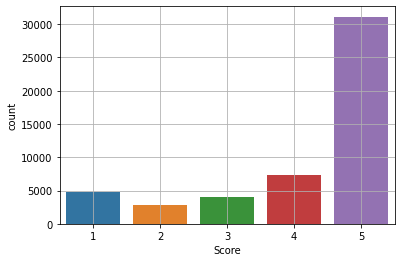

In [166]:
sns.countplot(x=data['Score'])
plt.grid()

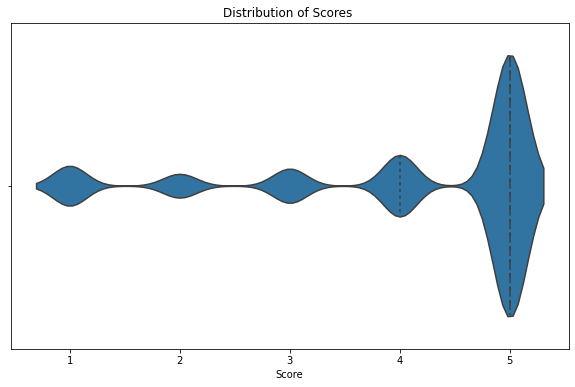

In [167]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Score', data=data, inner="quartile")
plt.title('Distribution of Scores ')
plt.show()

In [168]:

desired_samples_per_score = 10000
balanced_subsets = []

for score_value in range(1, 6):
    # Select data for the current score value
    data_score = data[data['Score'] == score_value]
    
    # Calculate the sample size based on the desired number of samples
    sample_size = min(desired_samples_per_score, len(data_score), len(data) // 5)
    
    # Sample data for the current score value
    data_score = data_score.sample(sample_size, random_state=42)
    
    # Add the sampled examples to the list
    balanced_subsets.append(data_score)

data_balanced = pd.concat(balanced_subsets, ignore_index=True)

data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [169]:
data_balanced['Score'].value_counts()

5    9999
4    7288
1    4720
3    4047
2    2811
Name: Score, dtype: int64

In [170]:
data_balanced['label'] = data_balanced['Score'].apply(lambda x: 1 if x > 3 else 0

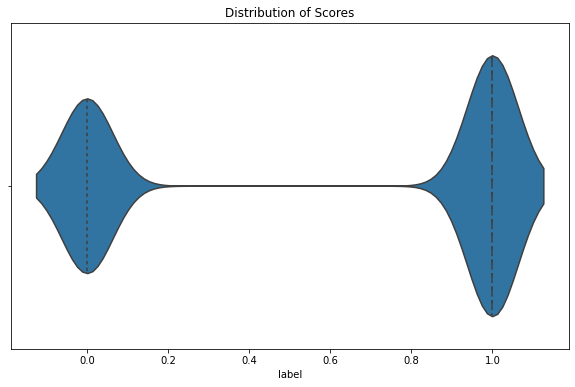

In [174]:

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', data=data_balanced, inner="quartile")
plt.title('Distribution of Scores')
plt.show()

# data cleaning

In [176]:
patterns_to_find = [r':\)', r':\(', r':D']

# Find occurrences in each text
match_positions = {pattern: [match.start() for text in data_balanced['Text'] for match in re.finditer(pattern, text)] for pattern in patterns_to_find}

# Check and print the results for each pattern
for pattern, positions in match_positions.items():
    if positions:
        print(f"The pattern '{pattern}' is found at positions: {positions}")
    else:
        print(f"The pattern '{pattern}' is not found in any text.")


The pattern ':\)' is found at positions: [351, 174, 516, 217, 287, 556, 470, 107, 217, 631, 226, 81, 187, 113, 561, 526, 322, 184, 160, 159, 1685, 1205, 404, 647, 505, 1208, 1019, 380, 460, 543, 105, 1508, 96, 360, 204, 294, 955, 139, 239, 195, 405, 261, 353, 205, 845, 641, 229, 143, 271, 277, 371, 107, 335, 979, 205, 261, 93, 74, 583, 1868, 411, 228, 342, 1733, 495, 198, 263, 131, 458, 369, 60, 901, 1627, 590, 528, 306, 65, 394, 808, 1193, 124, 773, 720, 697, 670, 1191, 223, 455, 192, 399, 38, 459, 327, 173, 517, 47, 1508, 88, 269, 123, 126, 129, 89, 837, 286, 158, 359, 337, 544, 223, 1347, 2228, 156, 221, 382, 214, 534, 353, 244, 537, 113, 1092, 154, 262, 15, 88, 604, 175, 582, 111, 1277, 710, 205, 835, 132, 129, 128, 345, 631, 1097, 268, 228, 187, 234, 583, 384, 562, 509, 140, 87, 547, 147, 136, 175, 347, 239, 90, 227, 452, 3554, 88, 83, 191, 366, 645, 259, 187, 198, 487, 282, 618, 208, 840, 807, 239, 330, 287, 394, 113, 650, 738, 368, 1501, 807, 259, 460, 785, 1806, 373, 893, 145, 

In [178]:
data_balanced['Text'][2]

'Great real coconut young coconut taste. Not the usual overwhelming sweet taste seen on other coconut water canned drinks.  Good on the environment. Made in Brazil. Even better.  You can really taste the fruit labelled on the product besides the coconut water taste'

In [179]:
patterns_to_remove = [r':\)', r':\(', r':D']

data_balanced = data_balanced.drop_duplicates()
def remove_patterns(text):
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
    return text


In [180]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'',text)

def remove_htmltags(text):
    html_pattern = re.compile(r'<.*?>')  
    return html_pattern.sub('', text)

def remove_extra_spaces_and_numbers(text):
    text = ' '.join(text.split())
    text = re.sub(r'\d+', '', text)
    return text



def remove_punctuations(text):
    translates = str.maketrans("", "", string.punctuation)
    return text.translate(translates)




In [82]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [181]:
def remove_stopwords(text):
    words = word_tokenize(text) # transfer the sentence into a list of words or tokens

    # Remove stopwords
    stop_words = set(stopwords.words('english')) #provides a set of common english stop words
    filtered_words = [word for word in words if word.lower() not in stop_words] #filters out the stop words from the list of words it cheks if each word in lower case , is not the set of stopwords

    cleaned_text = ' '.join(filtered_words)

    return cleaned_text


def lowercase(text):
    return text.lower()



In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

lemmatization to reduce the variety of the data 

In [182]:
#the difference between stemming and lematization is that a stemming chopping off the last letters but lemmatization uses a vocabulary for a meaningful sentence

def stem_text(text):
    stemmer = PorterStemmer()

    # Tokenize the text into words
    words = word_tokenize(text)

    # Stem each word
    stemmed_words = [stemmer.stem(word) for word in words]

    # Join the stemmed words back into a sentence
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text



# Apply all the preprocessing functions 

In [183]:
def clean_data(text):
    return lowercase(stem_text(remove_extra_spaces_and_numbers(remove_urls(remove_htmltags(remove_punctuations(remove_stopwords(remove_patterns(text))))))))


data_balanced['Text'] = data_balanced['Text'].apply(lambda text: clean_data(text))

In [184]:
data_balanced['Text'][2]

'great real coconut young coconut tast usual overwhelm sweet tast seen coconut water can drink good environ made brazil even better realli tast fruit label product besid coconut water tast'

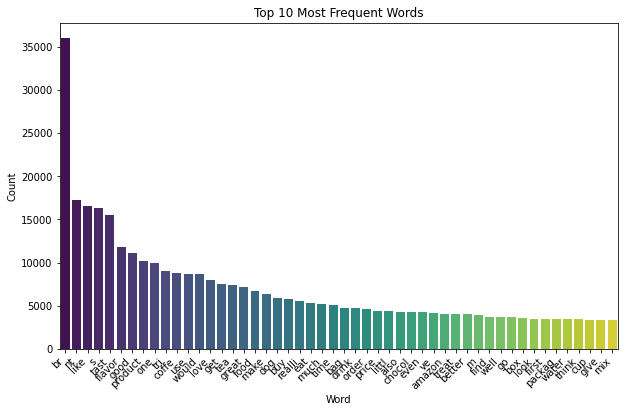

In [185]:
from collections import Counter
# Concatenate all the text in the specified column
text = ' '.join(data_balanced['Text'])

# Tokenize the text into words
words = text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Convert the Counter to a DataFrame
df_word_counts = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])

# Sort the DataFrame by Count in descending order
df_word_counts = df_word_counts.sort_values(by='Count', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Count', data=df_word_counts.head(50), palette='viridis')
plt.title('Top 10 Most Frequent Words')
plt.xticks(rotation=45, ha='right')
plt.show()


# Text vectorization Fast Text Model

In [1]:
pip install fasttext


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
pip install gensim 

  Using cached gensim-4.3.2-cp39-cp39-win_amd64.whl (24.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [214]:

text_data = data_balanced['Text'].tolist()
target_data = data_balanced['label'].tolist()


tokenized_data = [simple_preprocess(text) for text in text_data]

model = FastText(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Initialize an empty list to store the embeddings
embedding_data = []

# Loop through each text in the original data
for text in text_data:

    tokens = simple_preprocess(text)
    
    # Get word vectors for each token and filter out tokens not in the vocabulary
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    
    # If there are vectors, compute the mean vector and append to the list
    if vectors:
        mean_vector = sum(vectors) / len(vectors)
        embedding_data.append(mean_vector)
    else:
        # If no vectors found (all tokens out of vocabulary), append a zero vector
        embedding_data.append([0.0] * model.vector_size)

embedding_data = np.array(embedding_data)


## Split the data

In [215]:
X_train, X_test, y_train, y_test = train_test_split(embedding_data, target_data, test_size=0.2, random_state=42)

# building the logistic regression model

In [216]:
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [217]:

y_pred = model_2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)

Accuracy: 0.7928286852589641
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      2326
           1       0.81      0.86      0.83      3447

    accuracy                           0.79      5773
   macro avg       0.79      0.78      0.78      5773
weighted avg       0.79      0.79      0.79      5773



# CNN model

In [ ]:
#if your labels are binary (0 or 1), you should use binary cross-entropy as the loss function, not sparse categorical cross-entropy.

In [218]:

y_train = np.array(y_train)
y_test = np.array(y_test)


model_1 = Sequential()
model_1.add(Conv1D(128, 5, activation='relu', input_shape=(100, 1)))
model_1.add(GlobalMaxPooling1D())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))  #  'sigmoid' for binary classification and' to produce probability scores between 0 and 1.


model_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to match the input shape of the model
X_train1 = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test1 = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model_1.fit(X_train1, y_train, epochs=30, batch_size=32, validation_data=(X_test1, y_test))


loss, accuracy = model_1.evaluate(X_test1, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/30
722/722 [==============================] - 12s 13ms/step - loss: 0.6679 - accuracy: 0.5986 - val_loss: 0.6519 - val_accuracy: 0.5971
Epoch 2/30
722/722 [==============================] - 8s 11ms/step - loss: 0.6272 - accuracy: 0.6391 - val_loss: 0.5919 - val_accuracy: 0.6860
Epoch 3/30
722/722 [==============================] - 9s 12ms/step - loss: 0.5869 - accuracy: 0.6946 - val_loss: 0.5765 - val_accuracy: 0.7097
Epoch 4/30
722/722 [==============================] - 8s 12ms/step - loss: 0.5693 - accuracy: 0.7056 - val_loss: 0.5503 - val_accuracy: 0.7275
Epoch 5/30
722/722 [==============================] - 9s 12ms/step - loss: 0.5601 - accuracy: 0.7115 - val_loss: 0.5386 - val_accuracy: 0.7336
Epoch 6/30
722/722 [==============================] - 9s 12ms/step - loss: 0.5571 - accuracy: 0.7174 - val_loss: 0.5372 - val_accuracy: 0.7376
Epoch 7/30
722/722 [==============================] - 9s 12ms/step - loss: 0.5515 - accuracy: 0.7209 - val_loss: 0.5364 - val_accuracy: 0.736

In [219]:
from sklearn.metrics import classification_report

y_pred_prob = model_1.predict(X_test1)
y_pred_classes = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary classes (0 or 1)

classification_report_result = classification_report(y_test, y_pred_classes)

print("Classification Report:")
print(classification_report_result)


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      2326
           1       0.80      0.75      0.78      3447

    accuracy                           0.74      5773
   macro avg       0.74      0.74      0.74      5773
weighted avg       0.75      0.74      0.74      5773



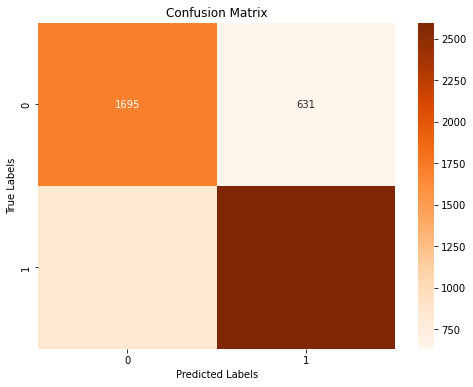

In [220]:

conf_matrix = confusion_matrix(y_test, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [235]:
from keras.models import load_model

model_1.save("model_1.h5")


def load_model():
    model = load_model("model_1.h5")
   
    return model

# test the model 

In [234]:

example_text = "i dont love the food!!!"

cleaned_example = clean_data(example_text)
print("Original Text:", example_text)
print("Cleaned Text:", cleaned_example)


tokenized_example = simple_preprocess(example_text)

example_embedding = []

# Loop through each token in the tokenized example
for token in tokenized_example:
    # Get the word vector for each token from the trained FastText model
    vector = model.wv[token] if token in model.wv else [0.0] * model.vector_size
    
    # Append the vector to the list
    example_embedding.append(vector)

# If there are vectors, compute the mean vector for the example
if example_embedding:
    mean_example_vector = np.mean(example_embedding, axis=0)
else:
    # If no vectors found (all tokens out of vocabulary), use a zero vector
    mean_example_vector = [0.0] * model.vector_size

# Convert the mean example vector to a NumPy array
example_data = np.array(mean_example_vector)

# Reshape the example data if needed
example_data = example_data.reshape((1, example_data.shape[0], 1))


predicted_prob = model_1.predict(example_data)
predicted_class = (predicted_prob > 0.5).astype(int)


if predicted_class[0][0] == 1:
    print("The model predicts: Positive")
else:
    print("The model predicts: Negative")


Original Text: i dont love the food!!!
Cleaned Text: dont love food
The model predicts: Negative
